#  Variational Encoders for Image Generation


In this notebook, we’ll get hands-on by implementing a classic Variational Autoencoder (VAE) to generate images.  

The idea is to build a solid understanding of VAEs so that we can later use them as a building block for time series forecasting or generation tasks, as we will see in other notebooks throughout the book.



## Import libraries

In [1]:
import torchvision
from torchvision.transforms import ToTensor 
from sklearn.model_selection import train_test_split
import torch
from genai4t.utils import set_random_state
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
from genai4t.plot_style import plot_style

In [2]:
# Environment configuration
ENV_CONFIG = {
    "random_state": 2024
}

# Data configuration for loading the MNIST dataset
DATA_CONFIG = {
    "data_dir": "'./artifacts/MNIST", # Directory where the MNIST dataset will be stored
    "batch_size": 64 # Batch size used during training
}

## Loading and Preparing the Data

The [MNIST](https://en.wikipedia.org/wiki/MNIST_database) database is a classic dataset of handwritten digits, consisting of grayscale images sized 28×28 pixels, with digits ranging from 0 to 9. The dataset includes 60,000 training images and 10,000 test images, and is widely used for benchmarking both image classification and generative modeling tasks. Below we download the dataset from `torchvision`


In [3]:
# to tensor transform our PIL images to a torch.Tensor,
# and normalize pixeles from 0 to 255 (uint8) to 0. to 1 (float32).
dataset = torchvision.datasets.MNIST(
    root=DATA_CONFIG["data_dir"], download=True,
    transform=ToTensor())

In [4]:
train_xy_dataset, test_xy_dataset = train_test_split(
    dataset,
    test_size=0.2,
    random_state=ENV_CONFIG["random_state"])

In [5]:
image, y_class = train_xy_dataset[0]

In [6]:
image.shape

torch.Size([1, 28, 28])

In [7]:
y_class

2

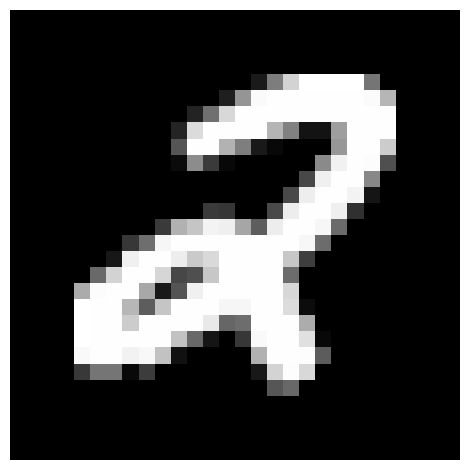

In [8]:
# Display the image using matplotlib
# Convert the tensor to NumPy format and use grayscale colormap
f, ax = plt.subplots()
ax.imshow(image.numpy()[0], cmap="gray")
ax.axis('off')
plot_style.apply_plot_style(ax)
plt.show()

In [9]:
# we can get rid of the class since we do unconditional image generation
train_ds = [x for x, _ in train_xy_dataset]
test_ds = [x for x, _ in test_xy_dataset]

In [10]:
# Create train dataloader
train_dl = DataLoader(
    train_ds,
    batch_size=DATA_CONFIG['batch_size'],
    shuffle=True)

# Create test dataloader
test_dl = DataLoader(
    test_ds,
    batch_size=DATA_CONFIG['batch_size'])

In [11]:
batch = next(iter(train_dl))

In [12]:
batch.shape

torch.Size([64, 1, 28, 28])

## VAE


The [Variational Autoencoder (VAE)](https://arxiv.org/abs/1312.6114) is a latent variable model where the marginal distribution over the latent variables is Gaussian, and both the encoder and decoder are modeled as conditional Gaussians, as described by Kingma (2013).  

The observations can be images, multivariate time series, etc. In this example, we use images as an illustrative case.

In this implementation, we will train a classical VAE using the reparameterization trick.   For more details about this model, please refer to Chapter 6 of the book.

# Loss Function

Let's assume:
- $ x_t $ is a single data point of dimension $d$
- $z_t$ is a latent vector of dimension $K$
- $ E $ is the encoder, and
- $ D $ is the decoder.

In our VAE, for each input $x_t$, the encoder $E(x_t)$ produces two outputs:
- a mean vector $\mu(x_t)$ and
- a variance vector $\sigma^2(x_t)$,

both of dimension $K$, where $K$ is the size of the latent space.

In VAEs, instead of sampling $z_t$ directly from the Gaussian $\mathcal{N}(\mu(x_t), \sigma(x_t)^2)$,  we use  the reparameterization trick:  

- First, sample some noise $\epsilon$ from a standard normal distribution:  $\epsilon^{(\ell)} \sim \mathcal{N}(0, I)$,  
- Then, compute the latent variable as:

$$
z_t^{({\ell})} = \mu(x_t) + \sigma(x_t) \odot \epsilon^{(\ell)}
$$

where $\odot$ means element-wise multiplication.

For each data point $x_t$, the VAE loss combines two terms:

### 1. Reconstruction Loss

This measures how well the decoder $D$ can reconstruct the original input $x_t$ from the sampled latent variable $z$.

In general, we can take $L$ samples of $\epsilon$ and average the reconstruction loss across these samples to make the estimate more accurate:

$$
\mathcal{L}_R(x_t) = \frac{1}{L} \sum_{\ell=1}^{L} ||x_t - D(z^{(\ell)}_t)||^2
$$

where each $z^{(\ell)}_t$ is sampled using a different $\epsilon^{(\ell)}$.

In practice though, using just one sample ($L=1$) works fine and is what most implementations do.   So most of the time, the reconstruction loss simplifies to:

$$
\mathcal{L}_R(x_t) = ||x_t - D(z_t)||^2
$$


### 2. KL Divergence Loss

This term drives the learned latent distribution to stay close to a standard normal distribution. We can compute the KL divergence analytically:

$$
KL(x_t) = \frac{1}{2} \sum_{i=1}^K \left(1 + \log(\sigma_{t,i}^2) - \mu_{t,i}^2 - \sigma_{t,i}^2\right)
$$

where $\mu_{t,i}$ and $\sigma_{t,i}$ are the $i$-th components of the encoder’s outputs for $x_t$.


### Total Loss

Finally, the total loss for a single data point $x_t$ combines the reconstruction loss and the KL divergence:

$$
\mathcal{L}(x_t) = w_r \mathcal{L}_R(x_t) + KL(x_t)
$$

In our example, we introduce a hyperparameter $ w_r $, known as the reconstruction weight (`reconstruction_wt` in our implementation), which controls the importance of the reconstruction term.

Then, we sum or average this loss per point across a batch of samples to obtain the batch loss.


As a side note, other implementations might also introduce a weight for the KL divergence term (for example, see [Beta-VAE](https://openreview.net/pdf?id=Sy2fzU9gl)).


### VAE Module

In the following implementation, we define a flexible `VAEModule` using PyTorch Lightning, which takes:

1. An encoder that returns the mean and log-variance of the latent variable distribution.
2. A decoder that reconstructs the input from the latent space.
3. A `VAESampler` (like `GaussSampler`) that implements the reparameterization trick.

We use the `BaseLightningModule` to handle standard training behavior, such as optimizer setup and training loop management.


In [13]:
import torch
import torch.nn as nn
from typing import Tuple, Protocol
import abc
from genai4t.model.core import BaseLightningModule


class VAESampler(Protocol):
    """Protocol defining the interface for VAE sampling strategies.
    
    This protocol ensures that any sampler implementation provides a method to sample
    from the latent space distribution using the mean and log variance parameters.
    """
    @abc.abstractmethod
    def sample(self, z_mean: torch.Tensor, z_log_var: torch.Tensor) -> torch.Tensor:
        """Sample from the latent space distribution.
        
        Args:
            z_mean: Mean of the latent space distribution, shape (batch_size, latent_dim)
            z_log_var: Log variance of the latent space distribution, shape (batch_size, latent_dim)
            
        Returns:
            Sampled latent vector, shape (batch_size, latent_dim)
        """
        raise NotImplementedError


class GaussSampler(VAESampler):
    """Implementation of the VAE sampler using Gaussian distribution.
    
    This sampler implements the reparameterization trick to enable gradient flow
    through the sampling process.
    """
    def sample(self, z_mean: torch.Tensor, z_log_var: torch.Tensor) -> torch.Tensor:
        """Sample from a Gaussian distribution using the reparameterization trick.
        
        Args:
            z_mean: Mean of the latent space distribution, shape (batch_size, latent_dim)
            z_log_var: Log variance of the latent space distribution, shape (batch_size, latent_dim)
            
        Returns:
            Sampled latent vector using z = μ + σ * ε where ε ~ N(0,1)
        """
        batch = z_mean.size(0)
        dim = z_mean.size(1)
        epsilon = torch.randn(batch, dim).to(z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon


class VAEModule(BaseLightningModule):
    """Variational Autoencoder (VAE) implementation using PyTorch Lightning.
    
    This module implements a VAE with configurable encoder, decoder, and sampling strategy.
    It handles both the reconstruction loss and KL divergence loss components.
    
    Attributes:
        encoder: Neural network that maps input to latent space parameters
        decoder: Neural network that maps latent space to reconstructed input
        sampler: Strategy for sampling from the latent space distribution
        reconstruction_wt: Weight for the reconstruction loss component
    """
    def __init__(
        self,
        encoder: nn.Module,
        decoder: nn.Module,
        sampler: VAESampler,
        reconstruction_wt: float = 1.,
        lr: float = 1e-3,
        weight_decay: float = 0.,
        ):
        super().__init__(lr=lr, weight_decay=weight_decay)

        self.encoder = encoder
        self.decoder = decoder
        self.sampler = sampler
        self.reconstruction_wt = reconstruction_wt

    def _compute_reconstruction_loss(self, x: torch.Tensor, reconstructed_x: torch.Tensor) -> torch.Tensor:
        """Compute the mean squared error reconstruction loss.
        
        Args:
            x: Original input tensor
            reconstructed_x: Reconstructed input tensor
            
        Returns:
            Sum of squared differences between input and reconstruction
        """
        err = torch.pow(x - reconstructed_x, 2)
        reconst_loss = torch.sum(err)
        return reconst_loss

    def compute_loss(
        self,
        x: torch.Tensor,
        reconstructed_x: torch.Tensor,
        z_mean: torch.Tensor,
        z_log_var: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Compute the total VAE loss and its components.
        
        The total loss is a weighted sum of reconstruction loss and KL divergence.
        
        Args:
            x: Original input tensor
            reconstructed_x: Reconstructed input tensor
            z_mean: Mean of the latent space distribution
            z_log_var: Log variance of the latent space distribution
            
        Returns:
            Tuple containing:
                - Total loss (weighted reconstruction + KL)
                - Reconstruction loss
                - KL divergence loss
        """
        bs = x.size(0)
        reconstruction_loss = self._compute_reconstruction_loss(x, reconstructed_x) / bs
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp()) / bs
        total_loss = self.reconstruction_wt * reconstruction_loss + kl_loss
        return total_loss, reconstruction_loss, kl_loss

    def step(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Perform a single forward pass and compute losses.
        
        Args:
            x: Input tensor
            
        Returns:
            Tuple containing:
                - Total loss
                - Reconstruction loss
                - KL divergence loss
        """
        z_mean, z_log_var = self.encoder(x)
        z = self.sampler.sample(z_mean, z_log_var)
        reconstructed_x = self.decoder(z)
        loss, rec_loss, kl_loss = self.compute_loss(x, reconstructed_x, z_mean, z_log_var)
        return loss, rec_loss, kl_loss

    def training_step(self, batch, batch_idx):
        """PyTorch Lightning training step.
        
        Args:
            batch: Input batch
            batch_idx: Index of the current batch
            
        Returns:
            Total loss for backpropagation
        """
        loss, rec_loss, kl_loss = self.step(batch)
        self.log('train_loss', loss.item(), on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_rec_loss', rec_loss.item(), on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_kl_loss', kl_loss.item(), on_step=True, on_epoch=True, prog_bar=True)
        return loss


We use the `VAEModule` as a flexible wrapper to train any VAE model by injecting custom encoder and decoder networks. To make this reusable across different implementations, we've refactored the `VAEModule` into `genai4t.chapters.vae`.

This allows us to easily import `VAEModule` and the `GaussSampler` in future notebooks or projects, streamlining the setup process for training VAEs.

In [14]:
from genai4t.chapters.vae import VAEModule, GaussSampler

### Encoder and Decoder

Since we are dealing with image data, we’ll use convolutional neural networks (CNNs) for both the encoder and decoder.

#### Encoder
The encoder processes a `28x28` grayscale image, applying a series of convolutional and pooling layers to downsample the input into a vector of `128` dimensions.  This vector is then used to produce the mean and log-variance of the latent variable distribution.

#### Decoder
The decoder performs the reverse: it takes a latent vector of size `latent_dim` and reconstructs the original image. This is achieved using transposed convolutions (also known as deconvolutions).

We use a final `Sigmoid` activation to ensure pixel values stay between 0 and 1.

In [15]:
import torch
import torch.nn as nn
from typing import Tuple

class MNISTEncoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 14x14 -> 14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 14x14 -> 7x7
            nn.Conv2d(64, 128, kernel_size=7)  # 7x7 -> 1x1
        )
        
        self.mu_layer = nn.Linear(128, latent_dim)
        self.logvar_layer = nn.Linear(128, latent_dim)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:    
        z = self.encoder(x)
        z = z.view(z.size(0), -1)  # Flatten for the linear layers
        z_mean = self.mu_layer(z)
        z_logvar = self.logvar_layer(z)
        return z_mean, z_logvar
    

class MNISTDecoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.decoder_input = nn.Linear(latent_dim, 128)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=7),  # 1x1 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()  # Output in range [0, 1] for pixel values
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        bs = z.size(0)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 1, 1)  # Reshape to (batch_size, channels, height, width)
        x_reconstructed = self.decoder(z)
        return x_reconstructed 


In [16]:
MODEL_CONFIG = {
    # Size of the latent space (dimensionality of z)
    "latent_dim": 26,
    # Learning rate
    "lr": 1e-3,
    # Weight for the reconstruction loss in the total loss
    "reconstruction_wt": 3.,
    # Total number of training steps (e.g., 10 epochs * number of batches per epoch)
    "num_steps": 10 * len(train_dl),
    # Directory path to save model checkpoints and artifacts
    "model_dir": "./artifacts/MNIST_VAE_2D"
}

In [17]:
encoder = MNISTEncoder(MODEL_CONFIG["latent_dim"])
decoder = MNISTDecoder(MODEL_CONFIG["latent_dim"])

In [18]:
from genai4t.model.utils import fit_model

In [19]:
vae = VAEModule(
    encoder=encoder,
    decoder=decoder,
    sampler=GaussSampler(),
    lr=MODEL_CONFIG['lr'],
    reconstruction_wt=MODEL_CONFIG["reconstruction_wt"])

Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | MNISTEncoder | 427 K  | train
1 | decoder | MNISTDecoder | 423 K  | train
-------------------------------------------------
850 K     Trainable params
0         Non-trainable params
850 K     Total params
3.403     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


total_n_params: 850741
deleting ./artifacts/MNIST_VAE_2D..


/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_steps=7500` reached.


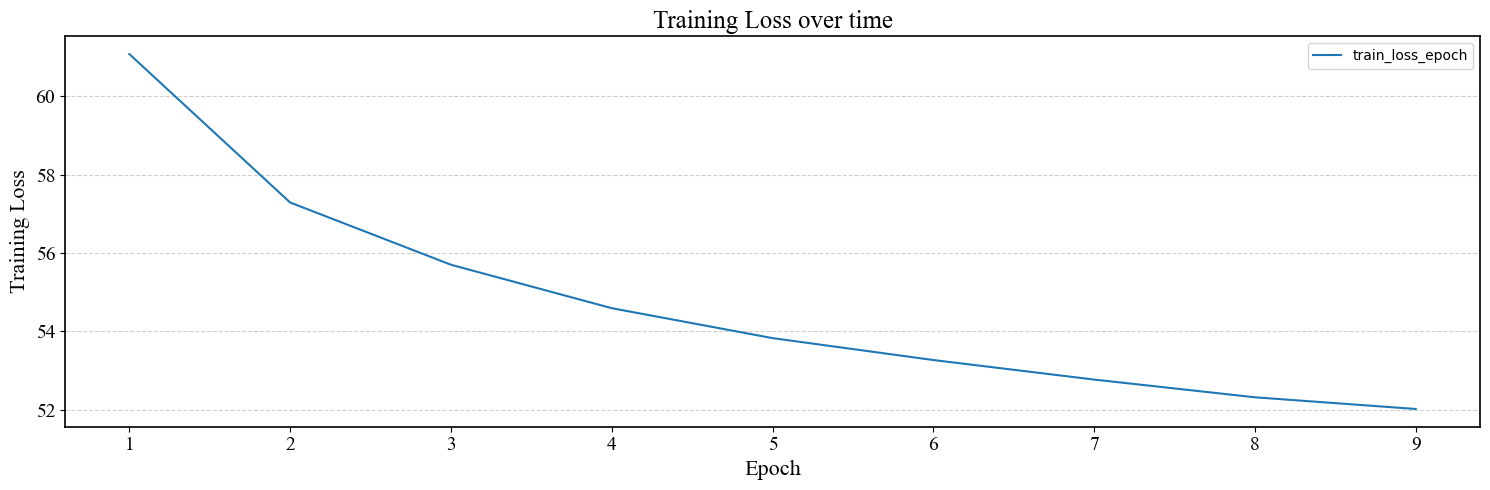

In [20]:
_ = fit_model(
    MODEL_CONFIG["model_dir"],
    vae,
    train_dl,
    num_steps=MODEL_CONFIG["num_steps"],
    random_state=ENV_CONFIG['random_state']
)

## Generation

Now it’s time to generate new images. 

### Generation from an Image

First, we’ll generate variations of a real image from the test set:

1. Pick a sample from the test set.
2. Use the encoder to obtain the parameters of the distribution in the latent space.
3. Sample latent vectors from this distribution.
4. Use the decoder to produce new images similar to the original.

In [21]:
def plot_generations(
    title: str,
    generations: torch.Tensor,
):
    generations = generations.numpy().reshape(-1, 28, 28)
    nrows = generations.shape[0] // 5
    f, axs = plt.subplots(nrows, 5, figsize=(20, 15))
    f.suptitle(title, fontsize=32)
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(generations[i], cmap="gray")
        ax.axis('off')
        plot_style.apply_plot_style(ax)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
    plt.show()

In [22]:
vae.eval()

VAEModule(
  (encoder): MNISTEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    )
    (mu_layer): Linear(in_features=128, out_features=26, bias=True)
    (logvar_layer): Linear(in_features=128, out_features=26, bias=True)
  )
  (decoder): MNISTDecoder(
    (decoder_input): Linear(in_features=26, out_features=128, bias=True)
    (decoder): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(7, 7), stride=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (3): ReLU()
      (4): ConvTran

In [23]:
set_random_state(ENV_CONFIG["random_state"])

# select a random from the dataset
idx = np.random.choice(len(test_ds))

Seed set to 2024


In [24]:
test_sample = test_ds[idx]

In [25]:
np_test_sample = test_sample.numpy()[0]

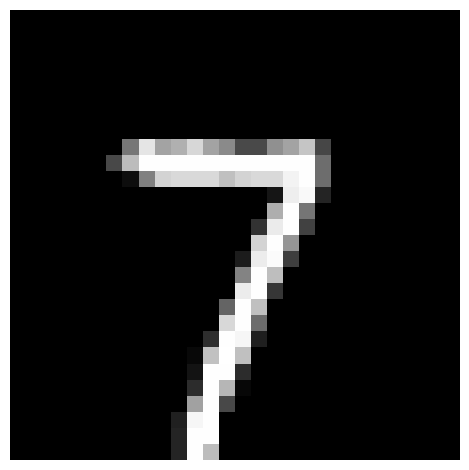

In [26]:
f, ax = plt.subplots()
ax.imshow(np_test_sample, cmap="gray")
ax.axis("off")
plot_style.apply_plot_style(ax)

In [27]:
with torch.no_grad():
    # use the encoder to compute the mean and variance of the distribution given the input image
    z_mean, z_logvar = vae.encoder(test_sample[torch.newaxis, :])
    # generate 10 latent representation drawn from the predicted distribution
    zs = torch.concatenate([vae.sampler.sample(z_mean, z_logvar) for _ in range(10)], dim=0)
    # generate images using the decoder
    generations = vae.decoder(zs)

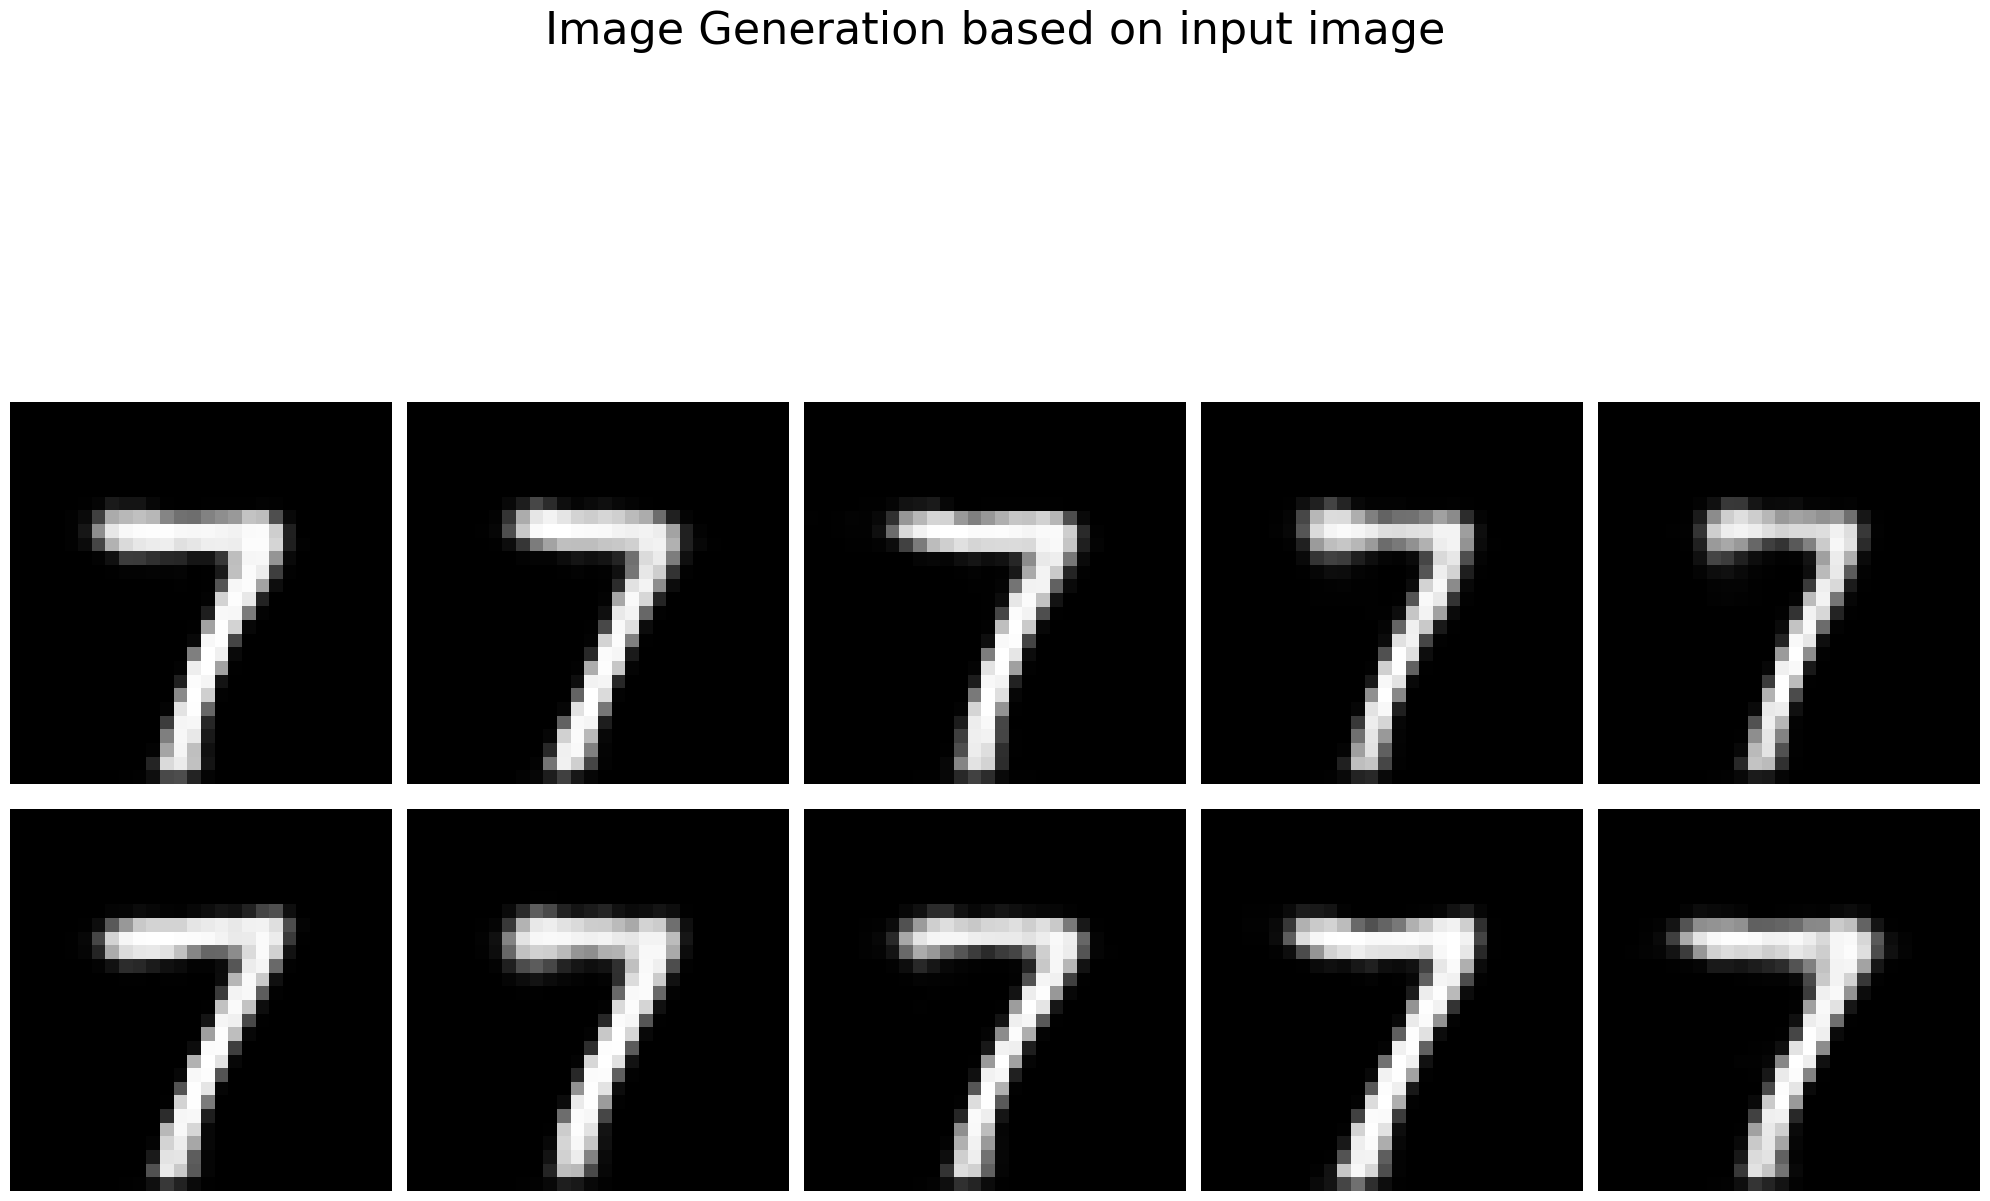

In [28]:
plot_generations("Image Generation based on input image", generations)

### Unconditional Generation

###  Unconditional Image Generation
We sample latent vectors from a standard normal distribution, $z \sim \mathcal{N}(\mathbf{0}, I)$, and pass them through the decoder to produce new synthetic images.


In [29]:
# sample latent representations from a standard gaussian distribution
set_random_state(ENV_CONFIG["random_state"])
zs = torch.randn(10, MODEL_CONFIG['latent_dim'])

Seed set to 2024


In [30]:
with torch.no_grad():
    # generate images using the decoder
    unconditional_generations = vae.decoder(zs)

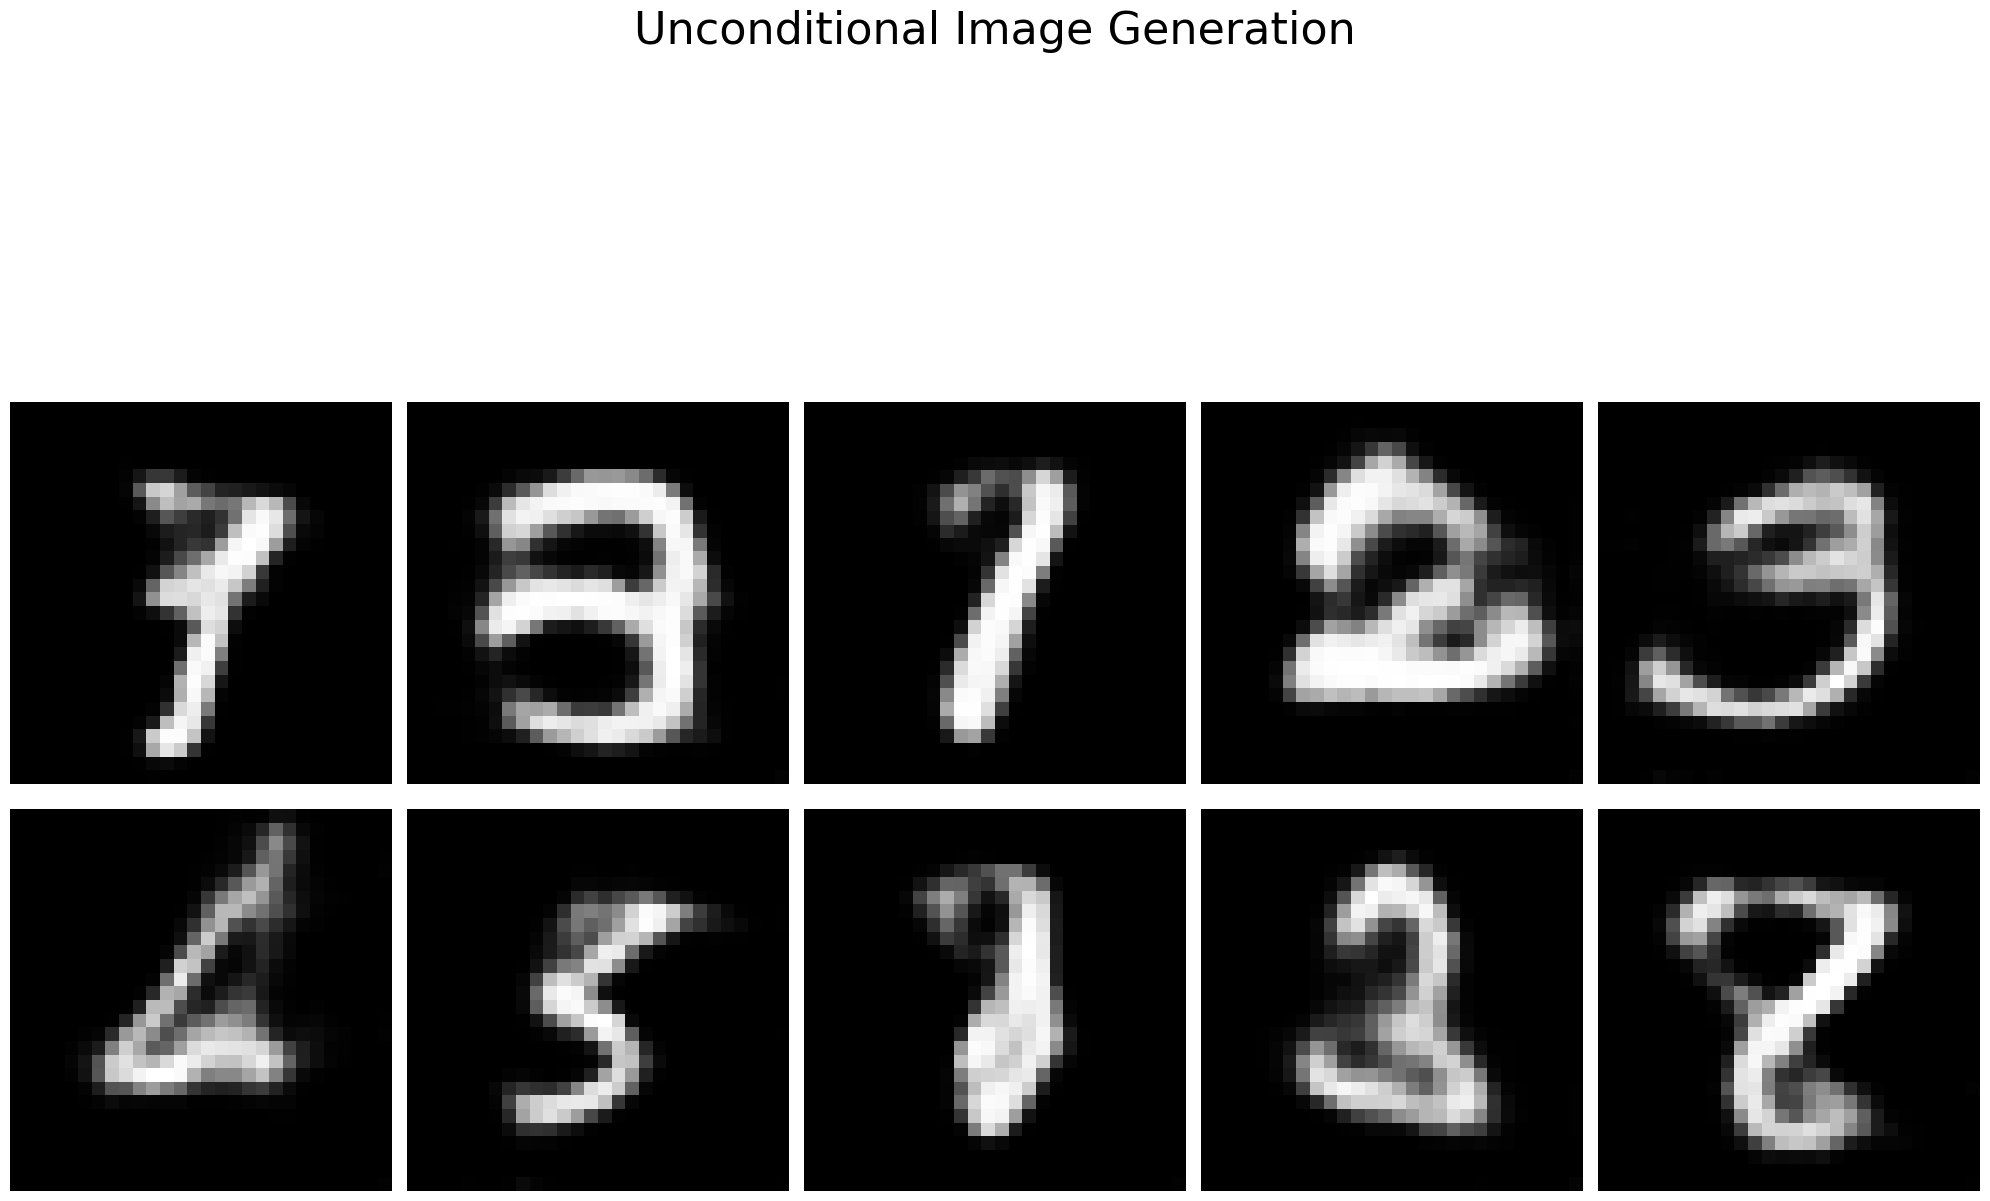

In [31]:
plot_generations("Unconditional Image Generation", unconditional_generations)